<a href="https://colab.research.google.com/github/luoChengwen/Tensorflow_test/blob/master/time_series_forecasting_intro2_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install tf-nightly-2.0-preview


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20190819


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 15
batch_size = 32
shuffle_buffer_size = 1000

In [162]:
#@title
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs = 300, callbacks=[lr_schedule])

Epoch 1/300
31/31 [==============================] - 7s 241ms/step - loss: 21.8340 - mae: 22.3463
Epoch 2/300
31/31 [==============================] - 1s 35ms/step - loss: 21.5533 - mae: 21.9342
Epoch 3/300
31/31 [==============================] - 1s 37ms/step - loss: 20.9660 - mae: 21.4609
Epoch 4/300
31/31 [==============================] - 1s 34ms/step - loss: 20.4244 - mae: 20.9485
Epoch 5/300
31/31 [==============================] - 1s 37ms/step - loss: 19.8792 - mae: 20.3814
Epoch 6/300
31/31 [==============================] - 1s 36ms/step - loss: 19.3136 - mae: 19.7013
Epoch 7/300
31/31 [==============================] - 1s 35ms/step - loss: 18.3178 - mae: 18.8772
Epoch 8/300
31/31 [==============================] - 1s 34ms/step - loss: 17.7760 - mae: 18.2977
Epoch 9/300
31/31 [==============================] - 1s 37ms/step - loss: 17.4940 - mae: 17.9046
Epoch 10/300
31/31 [==============================] - 1s 35ms/step - loss: 17.0035 - mae: 17.5235
Epoch 11/300
31/31 [========

[1e-08, 0.0001, 0, 30]

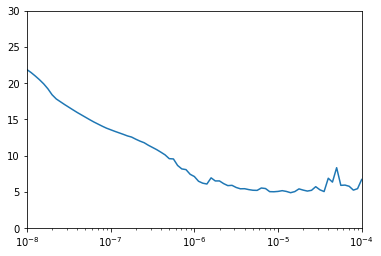

In [163]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

### so it seems that when lr is around 10 with the power of -5, the loss is small and stable. Thus in the following sessions, we weill retrain the model with lr = 10(-5)

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs = 300,verbose=0)

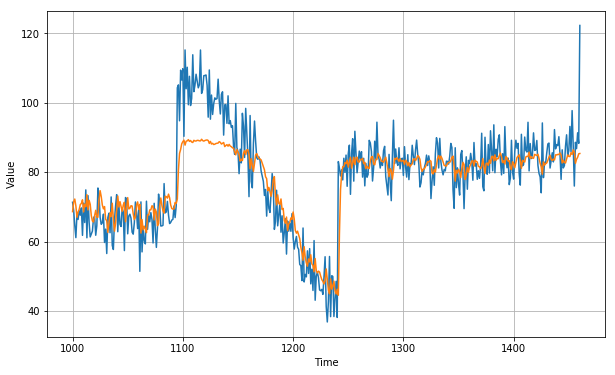

In [165]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [166]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.903092

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

# #-----------------------------------------------------------
# # Retrieve a list of list results on training and test data
# # sets for each training epoch
# #-----------------------------------------------------------
# mae=history.history['mae']
# loss=history.history['loss']

# epochs=range(len(loss)) # Get number of epochs

# #------------------------------------------------
# # Plot MAE and Loss
# #------------------------------------------------
# plt.figure()
# plt.plot(epochs, mae, 'r')
# plt.plot(epochs, loss, 'b')
# plt.title('MAE and Loss')
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(["MAE", "Loss"])



In [0]:
# compare loss func MAE VS MSE
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", metrics = ['mse'], optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history2 = model.fit(dataset,epochs = 300, verbose=0)

In [169]:
print(history2.history.keys())

dict_keys(['loss', 'mse'])


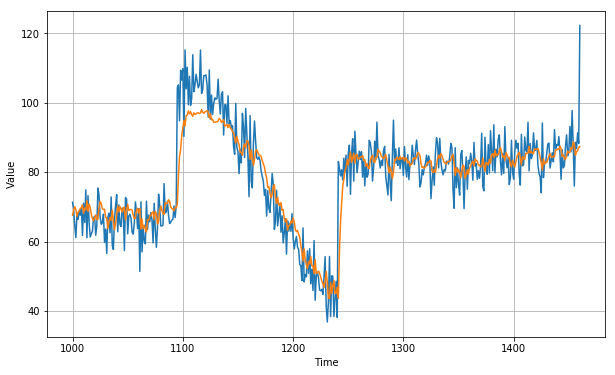

In [170]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [171]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

49.36301

In [172]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.2175736

300


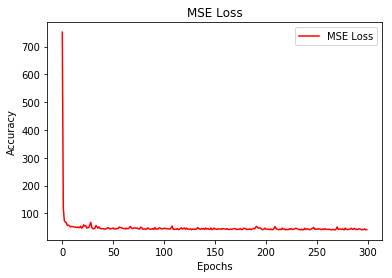

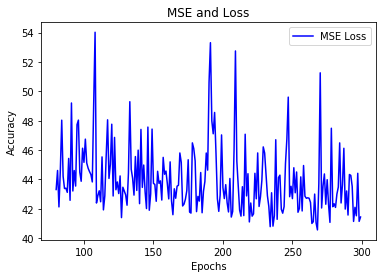

In [173]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------

loss=history2.history['loss']
mse=history2.history['mse']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.figure()
plt.plot(epochs, mse, 'r')

plt.title('MSE Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE Loss"])
print(len(epochs))


epochs_zoom = epochs[80:]
loss_zoom = loss[80:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.figure()
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE Loss"])



In [0]:
# ADD one more bidirectional layer (LSTM)
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))
hist33 = model.fit(dataset,epochs = 300, verbose = 0)

forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model33.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

In [0]:
# ADD one more bidirectional layer (LSTM)
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))
hist3 = model.fit(dataset,epochs = 300, verbose = 0)

In [175]:
print(hist3.history.keys())

dict_keys(['loss'])


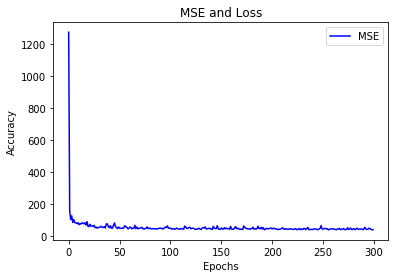

In [176]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=hist3.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.figure()
plt.plot(epochs, loss, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE"])




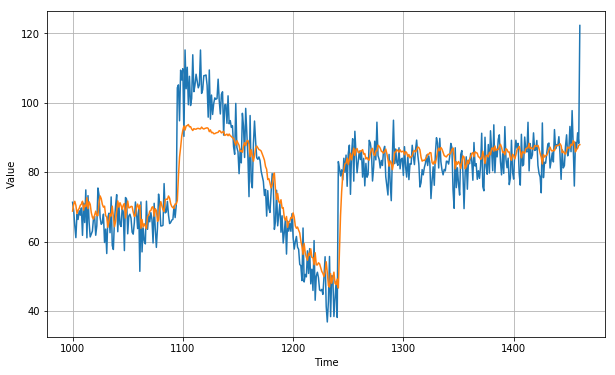

In [177]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)


In [178]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

5.862319


59.10717

In [0]:

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))
hist32 = model.fit(dataset,epochs = 300, verbose = 0)

forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)





In [180]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

8.505998


119.91275

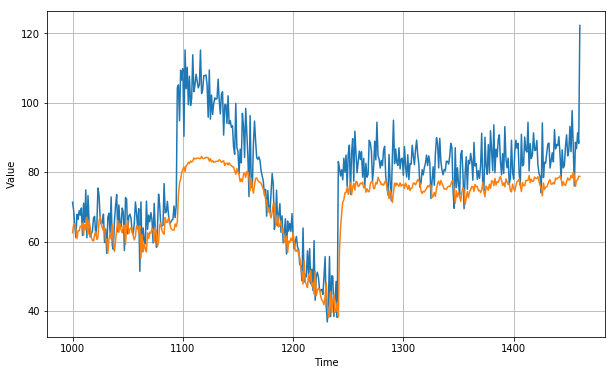

In [6]:
# ADD one more bidirectional layer (LSTM)
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))
hist32 = model.fit(dataset,epochs = 300, verbose = 0)

forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)


In [7]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

8.43679


120.21956

6.043276


70.27302

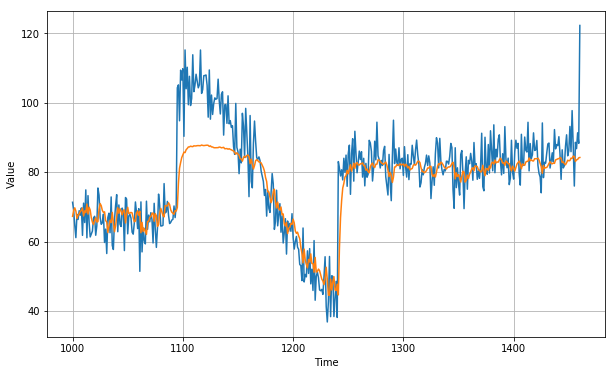

In [8]:
# ADD one more bidirectional layer (LSTM)
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, 128, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(30,activation='relu'),
  tf.keras.layers.Dense(1, activation = 'sigmoid'),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), metrics = ['mse'])
hist32 = model.fit(dataset,epochs = 300, verbose = 0)

forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()